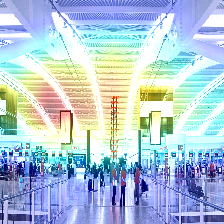

In [ ]:
import torch
from torch.autograd import Function
import numpy as np
import cv2
from torchvision import models, transforms
from google.colab.patches import cv2_imshow

# Define the GradCAM class
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradient = None
        self.model.eval()

        # Register the hook to save the feature maps and gradients
        self.model.layer4.register_forward_hook(self.save_feature_maps)
        self.model.layer4.register_backward_hook(self.save_gradient)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def backward(self, output, target_class):
        self.model.zero_grad()

        # Compute the gradients
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        if torch.cuda.is_available():
            one_hot = one_hot.cuda()  # Move to GPU if available
        output.backward(gradient=one_hot, retain_graph=True)

    def generate_cam(self):
        weights = torch.mean(self.gradient, dim=(2, 3)).squeeze()
        cam = torch.zeros(self.feature_maps.shape[2:], dtype=torch.float32)
        if torch.cuda.is_available():
            cam = cam.cuda()  # Move to GPU if available

        for i, w in enumerate(weights):
            cam += w * self.feature_maps[0][i, :, :]

        cam = np.maximum(cam.detach().cpu().numpy(), 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


# Load pre-trained ResNet-34
model = models.resnet34(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()  # Move model to GPU if available

# Instantiate GradCAM
grad_cam = GradCAM(model)

# Load and preprocess the image
image_path = '/content/test/airport_terminal/2000x1125-terminal-5-t5-heathrow-airportc-david-j-osborn.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image_tensor = transforms.ToTensor()(image).unsqueeze(0)
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()  # Move input tensor to GPU if available

# Perform forward and backward passes
output = grad_cam.forward(image_tensor)
target_class = torch.argmax(output, dim=1).item()
grad_cam.backward(output, target_class)

# Generate the Grad-CAM
cam = grad_cam.generate_cam()

# Superimpose the Grad-CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + image

# Display the result
cv2_imshow(superimposed_img)

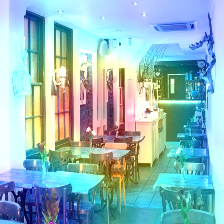

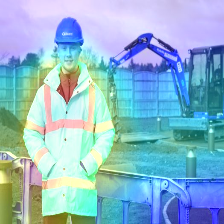

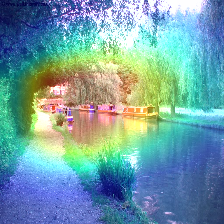

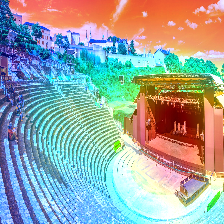